In [1]:
import os 
os.chdir("../../")

In [2]:
import glob
import numpy as np
from cids.util import metrics
from cids.util import misc_funcs as misc
from sklearn.metrics import matthews_corrcoef

In [3]:
best_runs = {}
host = 201

## Extract Baseline

In [4]:
result_dir = os.path.join(misc.root(), f"results/03_semisupervision/unsupervised/OpTC/MLPAE-{host}/BASE-{host}-1")
loss_type = "baseline"

aucs = []
scores = []
labels = []
labels_test = []
scores_test = []
scores_train = []
labels_train = []

seeds = glob.glob(os.path.join(result_dir, "*"))
baseline = {}
for seed in seeds:
    eval_scores = os.path.join(seed, "eval_scores.npy")
    eval_labels = os.path.join(seed, "eval_labels.npy")
    test_scores = os.path.join(seed, "test_scores.npy")
    test_labels = os.path.join(seed, "test_labels.npy")
    train_scores = os.path.join(seed, "train_scores.npy")
    train_labels = os.path.join(seed, "train_labels.npy")

    score = np.load(eval_scores)
    label = np.load(eval_labels)
    print(np.sum(label))
    score_test = np.load(test_scores)
    label_test = np.load(test_labels)
    print(np.sum(label_test))
    score_train = np.load(train_scores)
    label_train = np.load(train_labels)
    print(np.sum(label_train))
    auc = metrics.auc_score(label, score)

    scores.append(score)
    labels.append(label)
    scores_test.append(score_test)
    labels_test.append(label_test)
    scores_train.append(score_train)
    labels_train.append(label_train)
    aucs.append(auc)

mean_auc = np.mean(aucs)
baseline["seeds"] = seeds
baseline["scores"] = scores
baseline["labels"] = labels
baseline["scores_test"] = scores_test
baseline["labels_test"] = labels_test
baseline["scores_train"] = scores_train
baseline["labels_train"] = labels_train
best_runs["baseline"] = baseline


8654
30671
34447
8654
30671
34447
8654
30671
34447
8654
30671
34447
8654
30671
34447
8654
30671
34447
8654
30671
34447
8654
30671
34447
8654
30671
34447
8654
30671
34447


## Extract best run

In [5]:
def get_threshold_iqr(run):
    scores = np.load(os.path.join(run, "train_scores.npy"))
    labels = np.load(os.path.join(run, "train_labels.npy"))

    benign_scores = scores[labels == 0]
    q1 = np.quantile(benign_scores, 0.25)
    q3 = np.quantile(benign_scores, 0.75)
    iqr = q3 - q1
    threshold = (q3 + 1.5 * iqr)
    return threshold, (scores, labels)

In [6]:
loss_types = ["inverse", "reciprocal", "deepsad"]
result_dir = os.path.join(misc.root(), f"results/03_semisupervision/finetuned/MLPAE-{host}/SSL-FULL-ITER-{host}-{1 if host != 201 else 2}")


for loss_type in loss_types:
    runs = glob.glob(os.path.join(result_dir, f"{loss_type}--*"))
    best_run = {}
    best_mcc = 0
    for run in runs:
        print(f"Load run: {run}")
        mccs = []
        scores = []
        labels = []
        scores_test = []
        labels_test = []
        scores_train = []
        labels_train = []

        seeds = glob.glob(os.path.join(run, "*"))
        for seed in seeds:
            t, (score_train, label_train) = get_threshold_iqr(seed)
            eval_scores = os.path.join(seed, "eval_scores.npy")
            eval_labels = os.path.join(seed, "eval_labels.npy")
            test_scores = os.path.join(seed, "test_scores.npy")
            test_labels = os.path.join(seed, "test_labels.npy")

            score = np.load(eval_scores)
            label = np.load(eval_labels)

            score_test = np.load(test_scores)
            label_test = np.load(test_labels)

            mcc = metrics.mcc(label, (score > t).astype(int))
            
            scores.append(score)
            labels.append(label)
            scores_test.append(score_test)
            labels_test.append(label_test)
            scores_train.append(score_train)
            labels_train.append(label_train)
            mccs.append(mcc)

        mean_mcc = np.mean(mccs)
        if mean_mcc > best_mcc:
            best_mcc = mean_mcc
            best_run["seeds"] = seeds
            best_run["scores"] = scores
            best_run["labels"] = labels
            best_run["scores_test"] = scores_test
            best_run["labels_test"] = labels_test
            best_run["scores_train"] = scores_train
            best_run["labels_train"] = labels_train
    
    best_runs[loss_type] = best_run
    print(f"{loss_type}: Seeds {best_run['seeds']}")

Load run: /opt/gildemeister/gildemeister-implementation/results/03_semisupervision/finetuned/MLPAE-201/SSL-FULL-ITER-201-2/inverse--gamma1.25--lr2.17e-06
Load run: /opt/gildemeister/gildemeister-implementation/results/03_semisupervision/finetuned/MLPAE-201/SSL-FULL-ITER-201-2/inverse--gamma0.5--lr2.17e-07
Load run: /opt/gildemeister/gildemeister-implementation/results/03_semisupervision/finetuned/MLPAE-201/SSL-FULL-ITER-201-2/inverse--gamma0.25--lr1.085e-06
Load run: /opt/gildemeister/gildemeister-implementation/results/03_semisupervision/finetuned/MLPAE-201/SSL-FULL-ITER-201-2/inverse--gamma0.25--lr2.17e-06
Load run: /opt/gildemeister/gildemeister-implementation/results/03_semisupervision/finetuned/MLPAE-201/SSL-FULL-ITER-201-2/inverse--gamma0.75--lr1.085e-06
Load run: /opt/gildemeister/gildemeister-implementation/results/03_semisupervision/finetuned/MLPAE-201/SSL-FULL-ITER-201-2/inverse--gamma1.5--lr2.17e-07
Load run: /opt/gildemeister/gildemeister-implementation/results/03_semisuper

In [7]:
from matplotlib import pyplot as plt
def plot_hist(scores, labels, t, train_scores=None):
    
    # plt.hist(train_scores, bins=100, histtype='step', log=True)
    plt.hist(scores[labels==0], bins=200, histtype='step', log=True)
    plt.hist(scores[labels==1], bins=200, histtype='step', log=True)
    if train_scores is not None:
        plt.hist(train_scores, bins=200, histtype='step', log=True, color='grey', alpha=0.7)


    # Add the threshold as a vertical red dashed line
    plt.axvline(x=t, color='red', linestyle='--')
    if train_scores is None:
        plt.legend(['benign', 'malicious', 'threshold'])
    else:
        plt.legend(['benign', 'malicious', 'train_benign', 'threshold'])

    plt.show()

In [8]:
plotting = False
for loss_type in best_runs.keys():
    ts = []
    aucs = []
    rs = []
    ps = []
    f1s = []
    mccs = []
    fprs = []
    tps = []
    fps = []
    fns = []
    tns = []
    for (i, seed) in enumerate(best_runs[loss_type]["seeds"]):
        print(seed)
        t, (scores_train, label_train) = get_threshold_iqr(seed)
        scores = best_runs[loss_type]["scores_test"][i]
        labels = best_runs[loss_type]["labels_test"][i]
        if plotting:
            plot_hist(scores, labels, t, train_scores=scores_train[label_train == 0])

        tp = np.sum(scores[labels == 1] > t)
        fp = np.sum(scores[labels == 0] > t)
        fn = np.sum(scores[labels == 1] < t)
        tn = np.sum(scores[labels == 0] < t)

        f1 = metrics.f1_score(tp, fp, fn)
        recall = metrics.recall(tp, fn)
        precision = metrics.precision(tp, fp)
        mcc = matthews_corrcoef(labels, (scores > t).astype(int))
        auc = metrics.auc_score(labels, scores)
        fpr = metrics.fpr(fp, tn)

        ts.append(t)
        f1s.append(f1)
        ps.append(precision)
        rs.append(recall)
        fprs.append(fpr)
        mccs.append(mcc)
        aucs.append(auc)
        tps.append(tp)
        fps.append(fp)
        fns.append(fn)
        tns.append(tn)

    best_runs[loss_type]["f1s"] = f1s
    best_runs[loss_type]["ps"] = ps
    best_runs[loss_type]["rs"] = rs
    best_runs[loss_type]["fprs"] = fprs
    best_runs[loss_type]["mccs"] = mccs
    best_runs[loss_type]["thresholds"] = ts
    best_runs[loss_type]["aucs"] = aucs
    best_runs[loss_type]["tps"] = tps
    best_runs[loss_type]["fps"] = fps
    best_runs[loss_type]["fns"] = fns
    best_runs[loss_type]["tns"] = tns

/opt/gildemeister/gildemeister-implementation/results/03_semisupervision/unsupervised/OpTC/MLPAE-201/BASE-201-1/BASE-201-1-8
/opt/gildemeister/gildemeister-implementation/results/03_semisupervision/unsupervised/OpTC/MLPAE-201/BASE-201-1/BASE-201-1-9
/opt/gildemeister/gildemeister-implementation/results/03_semisupervision/unsupervised/OpTC/MLPAE-201/BASE-201-1/BASE-201-1-6
/opt/gildemeister/gildemeister-implementation/results/03_semisupervision/unsupervised/OpTC/MLPAE-201/BASE-201-1/BASE-201-1-1
/opt/gildemeister/gildemeister-implementation/results/03_semisupervision/unsupervised/OpTC/MLPAE-201/BASE-201-1/BASE-201-1-5
/opt/gildemeister/gildemeister-implementation/results/03_semisupervision/unsupervised/OpTC/MLPAE-201/BASE-201-1/BASE-201-1-0
/opt/gildemeister/gildemeister-implementation/results/03_semisupervision/unsupervised/OpTC/MLPAE-201/BASE-201-1/BASE-201-1-3
/opt/gildemeister/gildemeister-implementation/results/03_semisupervision/unsupervised/OpTC/MLPAE-201/BASE-201-1/BASE-201-1-7


In [9]:
for loss_type in best_runs.keys():
    print(loss_type + ":")
    print(f"\tauc = {np.mean(best_runs[loss_type]["aucs"]):.3f} +- {np.std(best_runs[loss_type]["aucs"]):.3f}")
    print(f"\tprecision_iqr = {np.mean(best_runs[loss_type]["ps"]):.3f} +- {np.std(best_runs[loss_type]["ps"]):.3f}")
    print(f"\trecall_iqr = {np.mean(best_runs[loss_type]["rs"]):.3f} +- {np.std(best_runs[loss_type]["rs"]):.3f}")
    print(f"\tfpr_iqr = {np.mean(best_runs[loss_type]["fprs"]):.3f} +- {np.std(best_runs[loss_type]["fprs"]):.3f}")
    print(f"\tf1_iqr = {np.mean(best_runs[loss_type]["f1s"]):.3f} +- {np.std(best_runs[loss_type]["f1s"]):.3f}")
    print(f"\tmcc_iqr = {np.mean(best_runs[loss_type]["mccs"]):.3f} +- {np.std(best_runs[loss_type]["mccs"]):.3f}")

baseline:
	auc = 0.985 +- 0.005
	precision_iqr = 0.636 +- 0.055
	recall_iqr = 0.867 +- 0.048
	fpr_iqr = 0.010 +- 0.002
	f1_iqr = 0.732 +- 0.041
	mcc_iqr = 0.736 +- 0.040
inverse:
	auc = 0.985 +- 0.006
	precision_iqr = 0.628 +- 0.054
	recall_iqr = 0.863 +- 0.048
	fpr_iqr = 0.010 +- 0.002
	f1_iqr = 0.725 +- 0.045
	mcc_iqr = 0.730 +- 0.044
reciprocal:
	auc = 0.988 +- 0.004
	precision_iqr = 0.885 +- 0.123
	recall_iqr = 0.803 +- 0.003
	fpr_iqr = 0.003 +- 0.004
	f1_iqr = 0.837 +- 0.069
	mcc_iqr = 0.837 +- 0.067
deepsad:
	auc = 0.853 +- 0.021
	precision_iqr = 0.200 +- 0.040
	recall_iqr = 0.756 +- 0.062
	fpr_iqr = 0.061 +- 0.016
	f1_iqr = 0.314 +- 0.051
	mcc_iqr = 0.367 +- 0.046


In [17]:
loss_type = "reciprocal"
best_seed = None
best_mcc = 0

for (i, seed) in enumerate(best_runs[loss_type]["seeds"]):
    if best_runs[loss_type]["mccs"][i] > best_mcc:
        best_seed = (i, seed)
        best_mcc = best_runs[loss_type]["mccs"][i]
print(best_seed)
print(best_mcc)

(2, '/opt/gildemeister/gildemeister-implementation/results/03_semisupervision/finetuned/MLPAE-201/SSL-FULL-ITER-201-2/reciprocal--gamma1.25--lr1.085e-06/seed10')
0.8721039847114063


In [55]:
# Print a summary table with tab-delimited columns
for loss_type, run in best_runs.items():
    print(f"{loss_type}:")
    print("Seed\tTP\tFP\tFN\tTN")
    for i, seed in enumerate(run["seeds"]):
        tp = run["tps"][i]
        fp = run["fps"][i]
        fn = run["fns"][i]
        tn = run["tns"][i]
        # Using only the last part of the seed path for brevity
        sshort = seed.split("/")[-1]
        print(f"{sshort}\t{tp}\t{fp}\t{fn}\t{tn}")
    print("\n" + "-"*50 + "\n")
    

baseline:
Seed	TP	FP	FN	TN
BASE-811-1-6	17355	73648	262	1735677
BASE-811-1-8	17334	22533	283	1786792
BASE-811-1-5	17350	36823	267	1772502
BASE-811-1-2	17355	54564	262	1754761
BASE-811-1-0	17356	23612	261	1785713
BASE-811-1-4	17346	47428	271	1761897
BASE-811-1-3	17332	18193	285	1791132
BASE-811-1-1	17329	13627	288	1795698
BASE-811-1-7	17335	41191	282	1768134
BASE-811-1-9	17339	55295	278	1754030

--------------------------------------------------

inverse:
Seed	TP	FP	FN	TN
seed1	17360	31445	257	1777880
seed6	17357	44563	260	1764762
seed10	17349	50714	268	1758611
seed4	17341	20675	276	1788650
seed2	17333	22558	284	1786767
seed3	17352	50614	265	1758711
seed7	17359	32901	258	1776424
seed5	17353	50029	264	1759296
seed9	17353	26550	264	1782775
seed8	17354	47638	263	1761687

--------------------------------------------------

reciprocal:
Seed	TP	FP	FN	TN
seed1	17330	6268	287	1803057
seed6	17545	79579	72	1729746
seed10	17554	64762	63	1744563
seed4	17329	3233	288	1806092
seed2	17337	25703	280	17

distribution_ssl_811_seed1


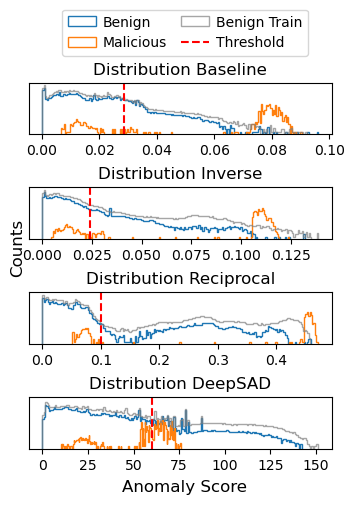

distribution_ssl_811_seed6


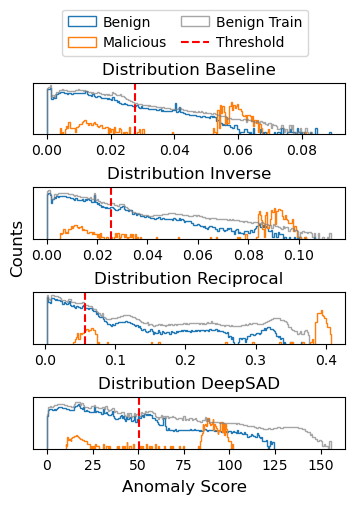

distribution_ssl_811_seed10


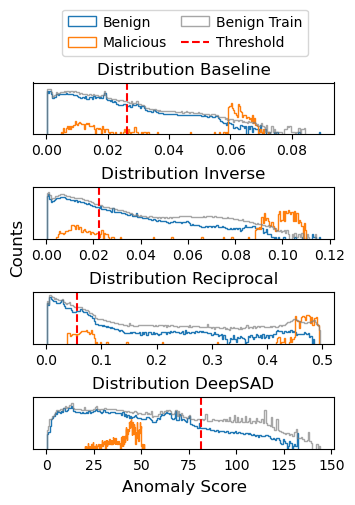

distribution_ssl_811_seed4


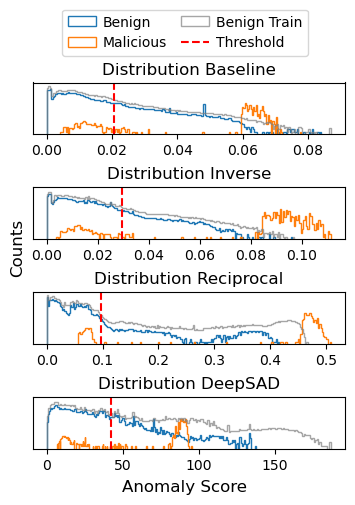

distribution_ssl_811_seed2


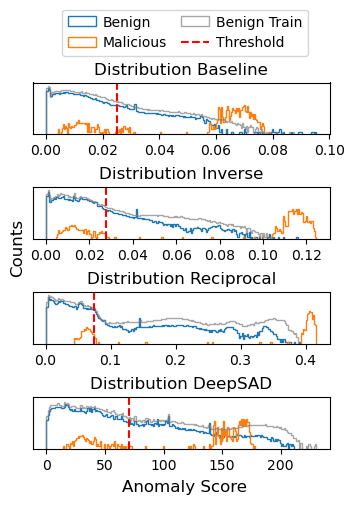

distribution_ssl_811_seed3


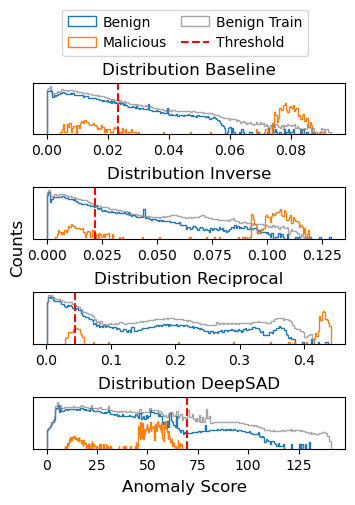

distribution_ssl_811_seed7


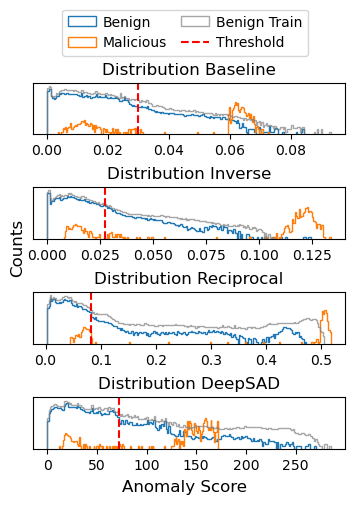

distribution_ssl_811_seed5


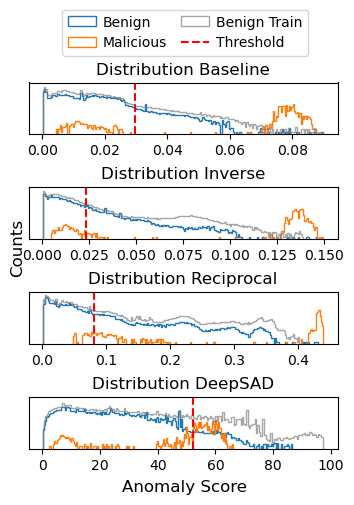

distribution_ssl_811_seed9


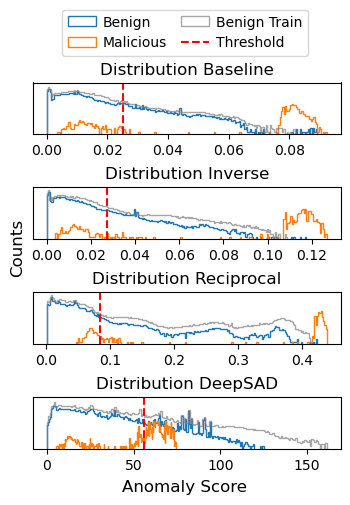

distribution_ssl_811_seed8


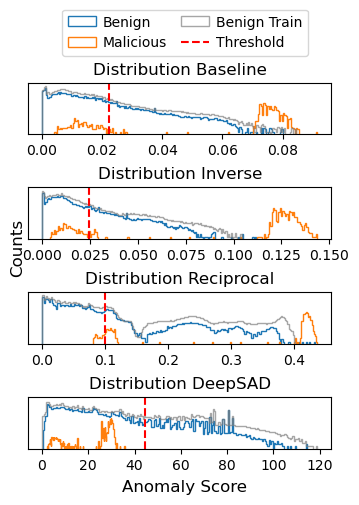

In [ ]:
small_plot = False  # Set to True for small plots, False for original size

plt.rcParamsDefault.update({'font.size': 12})
plot_over = ["baseline", "inverse", "reciprocal", "deepsad"]
for (i, seed) in enumerate(best_runs[loss_type]["seeds"]):
    if small_plot:
        height = 1.2 * len(plot_over)
        fig_width = 3.5
    else:
        height = 2 * len(plot_over)
        fig_width = 7
    fig, axs = plt.subplots(len(plot_over), 1, figsize=(fig_width, height), sharey=True)

    for mode, ax in zip(plot_over, axs):
        scores = best_runs[mode]["scores_test"][i]
        labels = best_runs[mode]["labels_test"][i]
        train_scores = best_runs[mode]["scores_train"][i]
        train_labels = best_runs[mode]["labels_train"][i]
        t = best_runs[mode]["thresholds"][i]

        ax.hist(scores[labels==0], bins=200, histtype='step', log=True, label="Benign", color="#1f77b4")
        ax.hist(scores[labels==1], bins=200, histtype='step', log=True, label ="Malicious", color="#ff7f0e")
        ax.hist(train_scores[train_labels==0], bins=200, histtype='step', log=True, color='grey', alpha=0.7, label="Benign Train")

        # Add the threshold as a vertical red dashed line
        ax.axvline(x=t, color='red', linestyle='--', label="Threshold")
        if not small_plot:
            ax.set_ylabel("Counts")
            ax.set_xlabel("Anomaly Score")
        else:
            ax.set_ylabel("")  # Remove individual y-labels
            ax.set_xlabel("")
            ax.set_yticklabels([])  # Remove y-tick labels, keep ticks
            ax.set_yticks([]) 

        ax.set_title(f"Distribution {mode.capitalize() if mode != 'deepsad' else 'DeepSAD'}")
                    
    # Add a single legend for both subplots
    handles, labels_ = axs[0].get_legend_handles_labels()
    if small_plot:
        fig.legend(
            handles, labels_, 
            loc='upper center', 
            ncol=2, 
            fontsize=10, 
            frameon=True, 
            bbox_to_anchor=(0.5, 1.08 if not small_plot else 1.01), 
            columnspacing=1.0, 
            handletextpad=0.5
        )
        # Add one y-label for the whole figure
        fig.text(0., 0.5, "Counts", va='center', rotation='vertical', fontsize=12)
        # Add one x-label for the whole figure at the bottom
        fig.text(0.5, 0., "Anomaly Score", ha='center', va='center', fontsize=12)
    else:
        fig.legend(handles, labels_, loc='upper center', ncol=4)

    fig.tight_layout()
    fig.subplots_adjust(top=(height-0.75) / height)  # Adjust to make room for legend
    sseed = seed.split("/")[-1]
    os.makedirs(os.path.join(misc.root(), f"plots/as_distribution/{host}"), exist_ok=True)
    fig.savefig(os.path.join(misc.root(), f"plots/as_distribution/{host}/ssl-{'-'.join(plot_over[1:])}_{sseed}_small.pdf" if small_plot else f"ssl-{'-'.join(plot_over[1:])}_{sseed}.pdf"), bbox_inches='tight')
    print(f"distribution_ssl_{host}_{sseed}")
    plt.show()

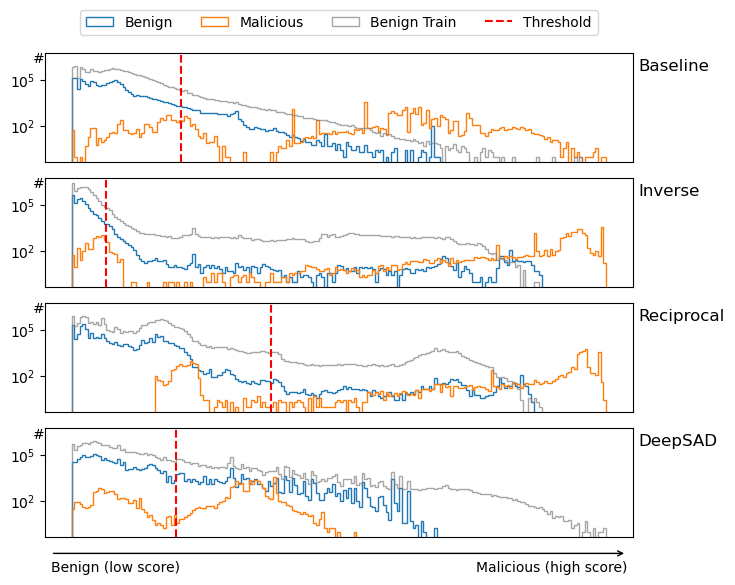

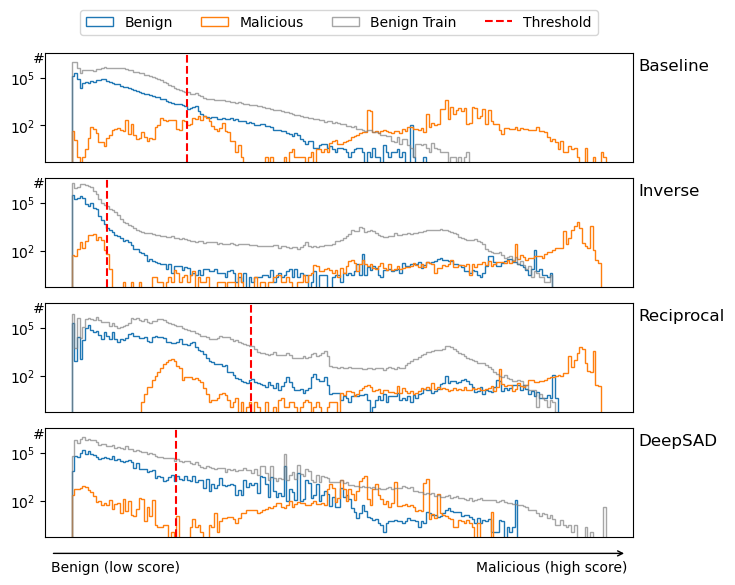

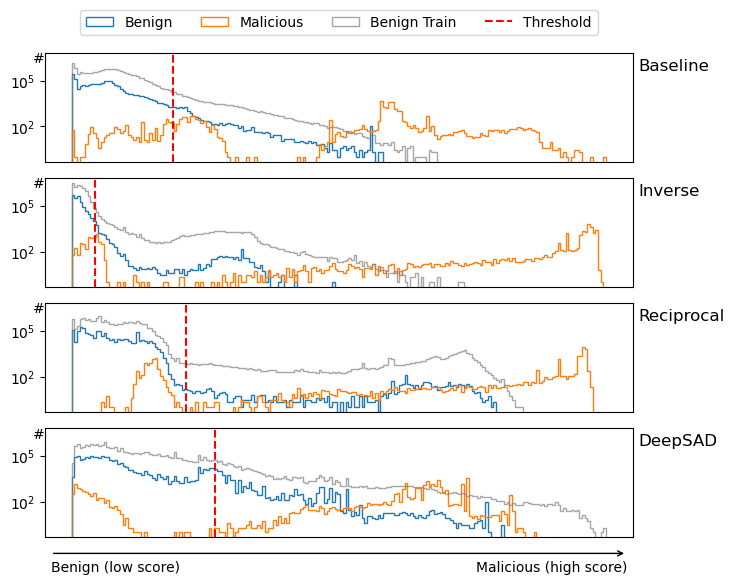

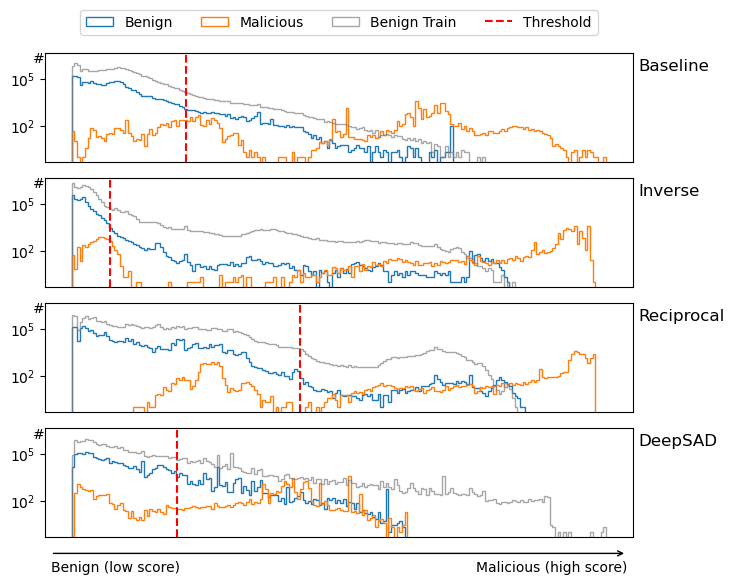

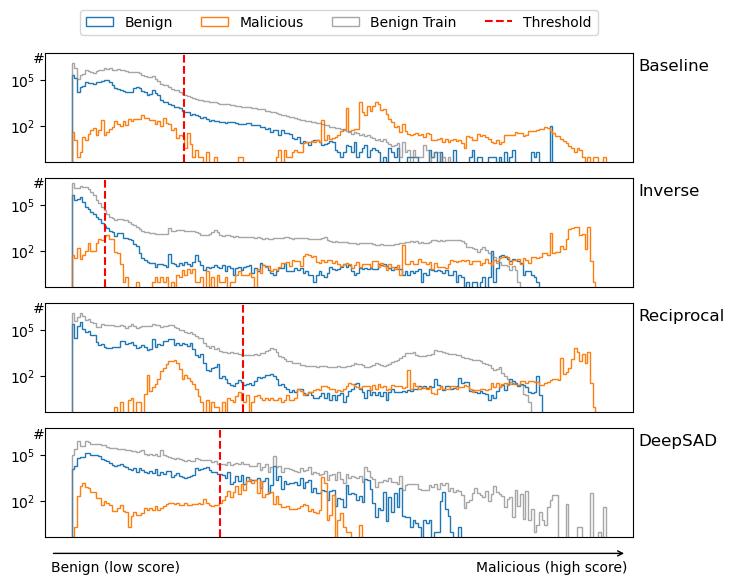

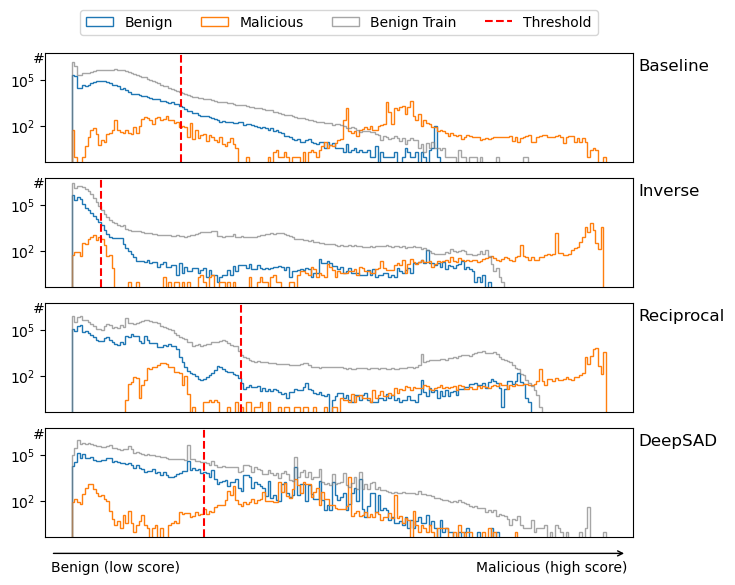

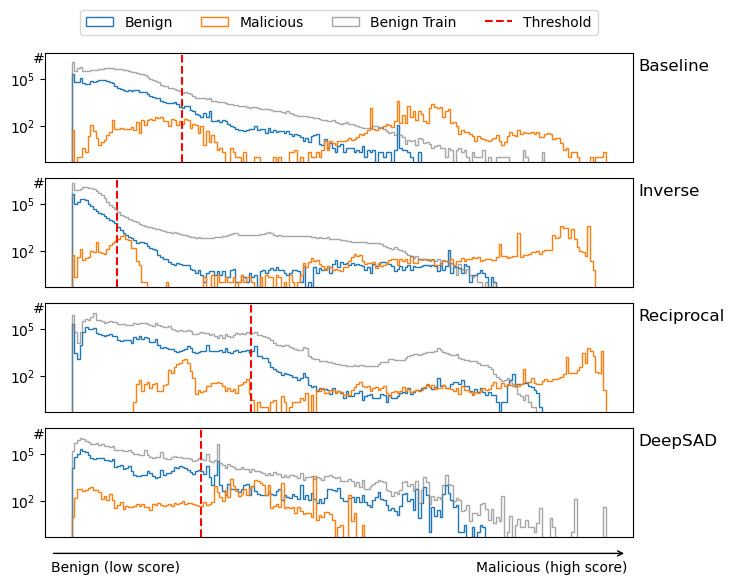

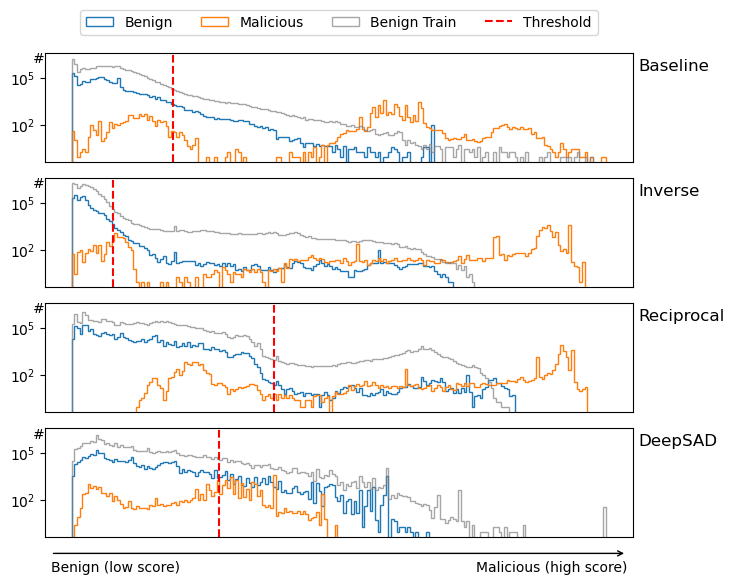

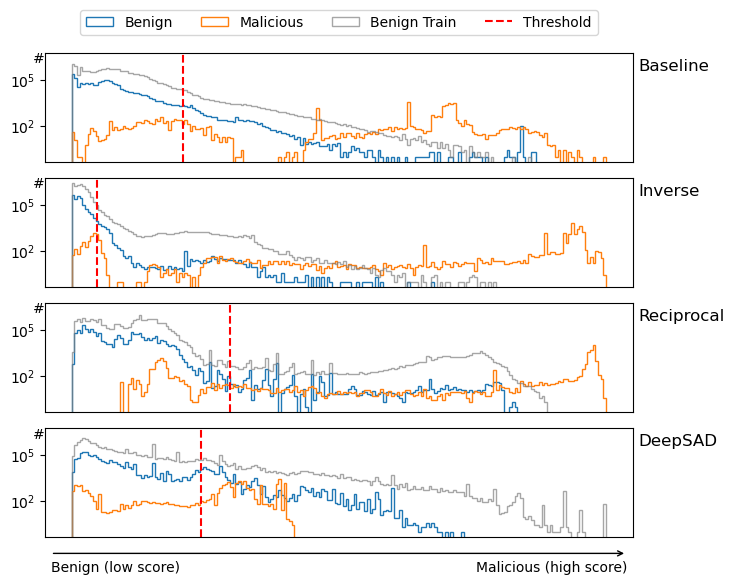

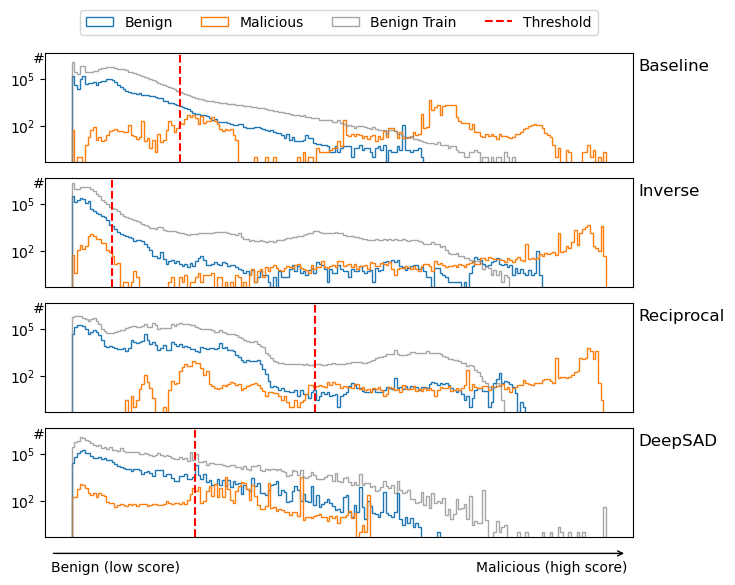

In [18]:
small_plot = False  # Kompaktere Darstellung
plt.rcParams.update({'font.size': 9, 'axes.titlesize': 10, 'axes.labelsize': 9, 'legend.fontsize': 8, 'xtick.labelsize': 8, 'ytick.labelsize': 10})

plot_over = ["baseline", "inverse", "reciprocal", "deepsad"]
for (i, seed) in enumerate(best_runs[loss_type]["seeds"]):
    if small_plot:
        height = 1.2 * len(plot_over)
        fig_width = 3.5
    else:
        height = 1.4 * len(plot_over)
        fig_width = 7
    fig, axs = plt.subplots(len(plot_over), 1, figsize=(fig_width, height), sharey=True)

    for mode_idx, (mode, ax) in enumerate(zip(plot_over, axs)):
        scores = best_runs[mode]["scores_test"][i]
        labels = best_runs[mode]["labels_test"][i]
        train_scores = best_runs[mode]["scores_train"][i]
        train_labels = best_runs[mode]["labels_train"][i]
        all_scores = np.concatenate([scores, train_scores])
        # Normierung auf [0,1]
        min_score, max_score = all_scores.min(), all_scores.max()
        norm = lambda x: (x - min_score) / (max_score - min_score + 1e-8)
        scores_n = norm(scores)
        train_scores_n = norm(train_scores)
        t = norm(best_runs[mode]["thresholds"][i])

        bins = np.linspace(0, 1, 200)

        ax.hist(scores_n[labels==0], bins=bins, histtype='step', log=True, label="Benign", color="#1f77b4")
        ax.hist(scores_n[labels==1], bins=bins, histtype='step', log=True, label="Malicious", color="#ff7f0e")
        ax.hist(train_scores_n[train_labels==0], bins=bins, histtype='step', log=True, color='grey', alpha=0.7, label="Benign Train")

        # Threshold als vertikale Linie
        ax.axvline(x=t, color='red', linestyle='--', label="Threshold")

        
        # y-Achsen-Beschriftung entfernen
        ax.set_ylabel("")

        # "#" oben links in die Achse setzen
        ax.text(-0.02, 1.01, "#", transform=ax.transAxes, ha='left', va='top', fontsize=10)#, fontweight='bold')
        # x-Achse ohne Beschriftung und Ticks
        ax.set_xlabel("")
        ax.set_xticklabels([])
        ax.set_xticks([])

        # Titel nach rechts oben, ohne "Distribution"
        ax.text(1.01, 0.95, mode.capitalize() if mode != 'deepsad' else 'DeepSAD',
                transform=ax.transAxes, va='top', ha='left', fontsize=12,)
        if mode_idx == len(plot_over) - 1:
            # Arrow
            ax.annotate(
                '', xy=(0.99, -0.15), xytext=(0.01, -0.15),
                xycoords='axes fraction', textcoords='axes fraction',
                arrowprops=dict(arrowstyle="->", color='black')
            )
            # Labels
            ax.text(0.01, -0.22, "Benign (low score)", transform=ax.transAxes, ha='left', va='top', fontsize=10)
            ax.text(0.99, -0.22, "Malicious (high score)", transform=ax.transAxes, ha='right', va='top', fontsize=10)

    # Kompakte Legende oben
    handles, labels_ = axs[0].get_legend_handles_labels()
    if small_plot:
        fig.legend(
            handles, labels_, 
            loc='upper center', 
            ncol=2, 
            fontsize=10, 
            frameon=True, 
            bbox_to_anchor=(0.5, 1.08 if not small_plot else 1.01), 
            columnspacing=1.0, 
            handletextpad=0.5
        )
        # Add one y-label for the whole figure
        fig.text(0., 0.5, "Counts", va='center', rotation='vertical', fontsize=12)
        # Add one x-label for the whole figure at the bottom
        fig.text(0.5, 0., "Anomaly Score", ha='center', va='center', fontsize=12)
    else:
        fig.legend(handles, labels_, loc='upper center', ncol=4, fontsize=10, bbox_to_anchor=(0.55, 1.04))
    fig.tight_layout()
    fig.subplots_adjust(top=0.95, hspace=0.15, left=0.13, right=0.97)
    sseed = seed.split("/")[-1]
    os.makedirs(os.path.join(misc.root(), f"plots/as_distribution/{host}"), exist_ok=True)
    fig.savefig(os.path.join(misc.root(), f"plots/as_distribution/{host}/ssl-{'-'.join(plot_over[1:])}_{sseed}_compact.pdf"), bbox_inches='tight')
    plt.show()

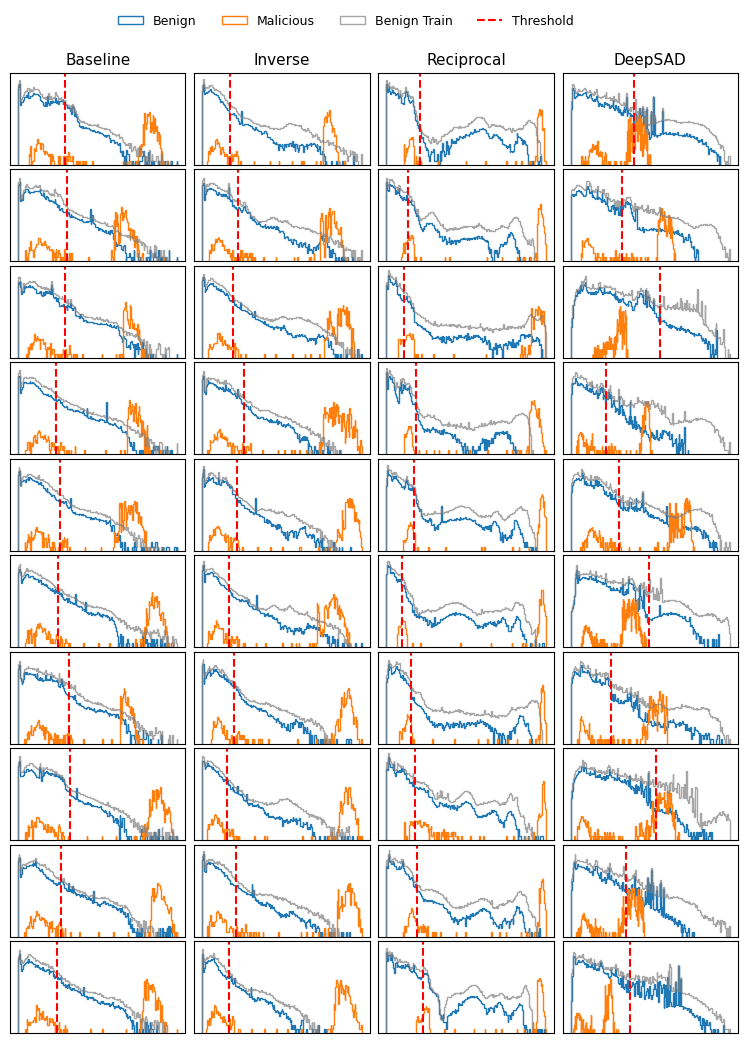

Saved minimal all-distributions plot to /opt/gildemeister/gildemeister-implementation/plots/as_distribution/811/all_distributions_minimal_a4.pdf


In [35]:
from matplotlib.backends.backend_pdf import PdfPages

# Minimal grid plot for appendix: each row = seed, each col = mode, with column titles and a single legend above
plot_over = ["baseline", "inverse", "reciprocal", "deepsad"]
seeds = best_runs[plot_over[0]]["seeds"]
num_seeds = len(seeds)

fig, axs = plt.subplots(num_seeds, len(plot_over), figsize=(2*len(plot_over), 1*num_seeds), sharey=True)

# Add column titles
for col, mode in enumerate(plot_over):
    ax = axs[0, col] if num_seeds > 1 else axs[col]
    ax.set_title(mode.capitalize() if mode != "deepsad" else "DeepSAD", fontsize=11)

# Plot distributions
for row in range(num_seeds):
    for col, mode in enumerate(plot_over):
        ax = axs[row, col] if num_seeds > 1 else axs[col]
        scores = best_runs[mode]["scores_test"][row]
        labels = best_runs[mode]["labels_test"][row]
        train_scores = best_runs[mode]["scores_train"][row]
        train_labels = best_runs[mode]["labels_train"][row]
        t = best_runs[mode]["thresholds"][row]
        h0 = ax.hist(scores[labels==0], bins=200, histtype='step', log=True, color="#1f77b4", label="Benign")
        h1 = ax.hist(scores[labels==1], bins=200, histtype='step', log=True, color="#ff7f0e", label="Malicious")
        h2 = ax.hist(train_scores[train_labels==0], bins=200, histtype='step', log=True, color='grey', alpha=0.7, label="Benign Train")
        vline = ax.axvline(x=t, color='red', linestyle='--', label="Threshold")
        ax.set_xticks([])
        ax.set_yticks([])

# Create a single legend above the column titles
handles, labels = axs[0,0].get_legend_handles_labels() if num_seeds > 1 else axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=4, fontsize=9, frameon=False, bbox_to_anchor=(0.5, 1.04))

fig.subplots_adjust(wspace=0.05, hspace=0.05, left=0.08, right=0.99, top=0.97, bottom=0.01)

# Save to PDF sized for A4
pdf_path = os.path.join(misc.root(), f"plots/as_distribution/{host}/all_distributions_minimal_a4.pdf")
# fig.set_size_inches(8.27, 11.69)  # A4 size in inches (210mm x 297mm)
fig.savefig(pdf_path, bbox_inches='tight', dpi=300)
plt.show()
plt.close(fig)
print(f"Saved minimal all-distributions plot to {pdf_path}")

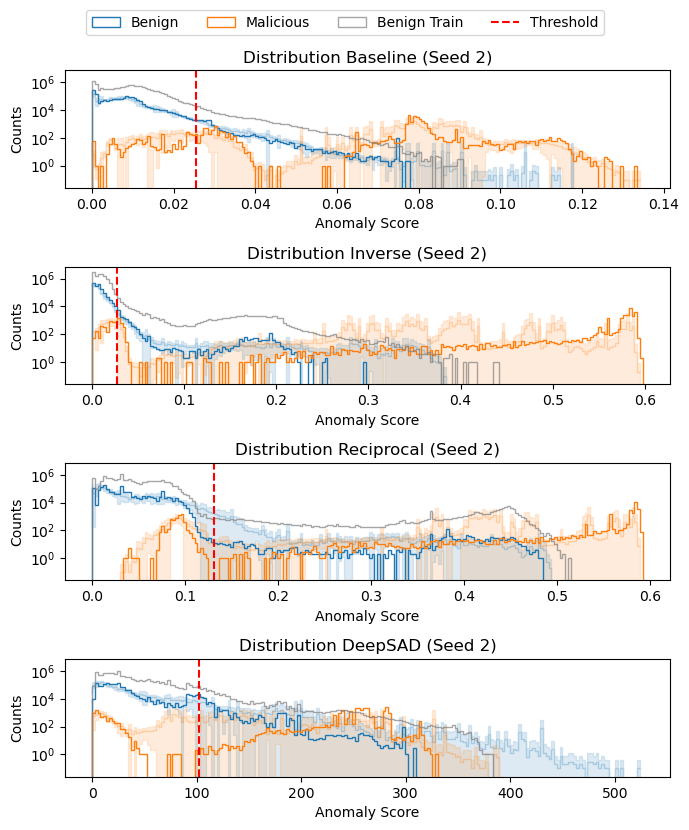

In [23]:
# Plot the distribution for a single seed, with other seeds as background error bands

plot_over = ["baseline", "inverse", "reciprocal", "deepsad"]
seed_idx = 2  # Change this to select the reference seed (e.g., 0 for the first seed)

fig, axs = plt.subplots(len(plot_over), 1, figsize=(7, 2 * len(plot_over)), sharey=True)

for mode_idx, (mode, ax) in enumerate(zip(plot_over, axs)):
    # Get all seeds' scores and labels for this mode
    all_scores = best_runs[mode]["scores_test"]
    all_labels = best_runs[mode]["labels_test"]
    all_train_scores = best_runs[mode]["scores_train"]
    all_train_labels = best_runs[mode]["labels_train"]
    all_thresholds = best_runs[mode]["thresholds"]
    n_seeds = len(all_scores)

    # Reference seed
    scores = all_scores[seed_idx]
    labels = all_labels[seed_idx]
    train_scores = all_train_scores[seed_idx]
    train_labels = all_train_labels[seed_idx]
    t = all_thresholds[seed_idx]

    # Plot background histograms for other seeds (as error bands or filled lines)
    bins = np.linspace(min([s.min() for s in all_scores]), max([s.max() for s in all_scores]), 200)
    # For each class (benign/malicious), stack all histograms
    for label_val, color, label_name in zip([0, 1], ["#1f77b4", "#ff7f0e"], ["Benign", "Malicious"]):
        hists = []
        for i in range(n_seeds):
            h, _ = np.histogram(all_scores[i][all_labels[i]==label_val], bins=bins)
            hists.append(h)
        if hists:
            hists = np.array(hists)
            mean_hist = np.mean(hists, axis=0)
            std_hist = np.std(hists, axis=0)
            ax.fill_between(bins[:-1], mean_hist, mean_hist+std_hist, color=color, alpha=0.15, step="pre")
            ax.fill_between(bins[:-1], mean_hist-std_hist, mean_hist, color=color, alpha=0.15, step="pre")

    # Plot the reference seed as a line
    ax.hist(scores[labels==0], bins=bins, histtype='step', log=True, label="Benign", color="#1f77b4")
    ax.hist(scores[labels==1], bins=bins, histtype='step', log=True, label ="Malicious", color="#ff7f0e")
    ax.hist(train_scores[train_labels==0], bins=bins, histtype='step', log=True, color='grey', alpha=0.7, label="Benign Train")
    ax.axvline(x=t, color='red', linestyle='--', label="Threshold")
    ax.set_ylabel("Counts")
    ax.set_xlabel("Anomaly Score")
    ax.set_title(f"Distribution {mode.capitalize() if mode != 'deepsad' else 'DeepSAD'} (Seed {seed_idx})")

handles, labels_ = axs[0].get_legend_handles_labels()
fig.legend(handles, labels_, loc='upper center', ncol=4,  bbox_to_anchor=(0.5, 1.04))
fig.tight_layout()
plt.show()

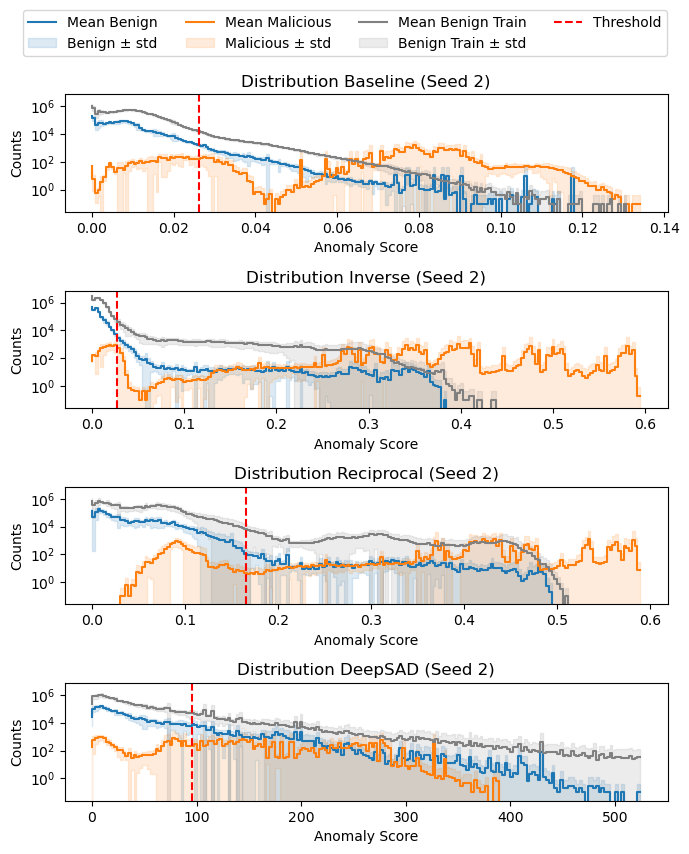

In [36]:
# Plot the distribution for a single seed, with other seeds as background error bands

plot_over = ["baseline", "inverse", "reciprocal", "deepsad"]
seed_idx = 2  # Change this to select the reference seed (e.g., 0 for the first seed)

fig, axs = plt.subplots(len(plot_over), 1, figsize=(7, 2 * len(plot_over)), sharey=True)

for mode_idx, (mode, ax) in enumerate(zip(plot_over, axs)):
    # Get all seeds' scores and labels for this mode
    all_scores = best_runs[mode]["scores_test"]
    all_labels = best_runs[mode]["labels_test"]
    all_train_scores = best_runs[mode]["scores_train"]
    all_train_labels = best_runs[mode]["labels_train"]
    all_thresholds = best_runs[mode]["thresholds"]
    n_seeds = len(all_scores)

    # Reference seed
    t = np.mean(all_thresholds)

    # Plot mean histogram with error bands for each class (benign/malicious)
    bins = np.linspace(min([s.min() for s in all_scores]), max([s.max() for s in all_scores]), 200)
    for label_val, color, label_name in zip([0, 1], ["#1f77b4", "#ff7f0e"], ["Benign", "Malicious"]):
        hists = []
        for i in range(n_seeds):
            h, _ = np.histogram(all_scores[i][all_labels[i]==label_val], bins=bins)
            hists.append(h)
        if hists:
            hists = np.array(hists)
            mean_hist = np.mean(hists, axis=0)
            std_hist = np.std(hists, axis=0)
            # Plot mean as a line
            ax.step(bins[:-1], mean_hist, where="pre", color=color, label=f"Mean {label_name}")
            # Plot error band
            ax.fill_between(bins[:-1], mean_hist-std_hist, mean_hist+std_hist, color=color, alpha=0.15, step="pre", label=f"{label_name} ± std")
    
    train_benign_hists = []
    for i in range(n_seeds):
        h, _ = np.histogram(all_train_scores[i][all_train_labels[i]==0], bins=bins)
        train_benign_hists.append(h)
    train_benign_hists = np.array(train_benign_hists)
    mean_train_benign = np.mean(train_benign_hists, axis=0)
    std_train_benign = np.std(train_benign_hists, axis=0)
    ax.step(bins[:-1], mean_train_benign, where="pre", color="grey", label="Mean Benign Train")
    ax.fill_between(bins[:-1], mean_train_benign-std_train_benign, mean_train_benign+std_train_benign, color="grey", alpha=0.15, step="pre", label="Benign Train ± std")


    ax.set_yscale('log')
    ax.axvline(x=t, color='red', linestyle='--', label="Threshold")
    ax.set_ylabel("Counts")
    ax.set_xlabel("Anomaly Score")
    ax.set_title(f"Distribution {mode.capitalize() if mode != 'deepsad' else 'DeepSAD'} (Seed {seed_idx})")

handles, labels_ = axs[0].get_legend_handles_labels()
fig.legend(handles, labels_, loc='upper center',  bbox_to_anchor=(0.5, 1.07), ncol=4)
fig.tight_layout()
plt.show()